# 6. Decomposition

Take series and break it down into its components
- trend
- seasonality 
- residul

## 6.2 Moving Average Smoothing
### Bringing out the trend


In [79]:
import pandas as pd
import matplotlib.pyplot as plt

def ma_smooth (series, num_days):
    answer = series - series
    for i in range(num_days):
        answer = answer + series.shift(i)
    return answer/num_days

plt.rcParams['figure.figsize'] = [15,10]


In [43]:
series = [1, 2, 1, 3, 2, 3,3,2,1,2,2,3,2,3,1,3,4,2,1,2,3]
ma3_test_df = pd.DataFrame(series, columns=['Observed'])
ma3_test_df['Smoothed_ma3'] = ma_smooth(ma3_test_df['Observed'], 3)
ma3_test_df.head(6)

,Observed,Smoothed_ma3
0,1,NaN
1,2,NaN
2,1,1.333333
3,3,2.000000
4,2,2.000000
5,3,2.666667


<AxesSubplot:>

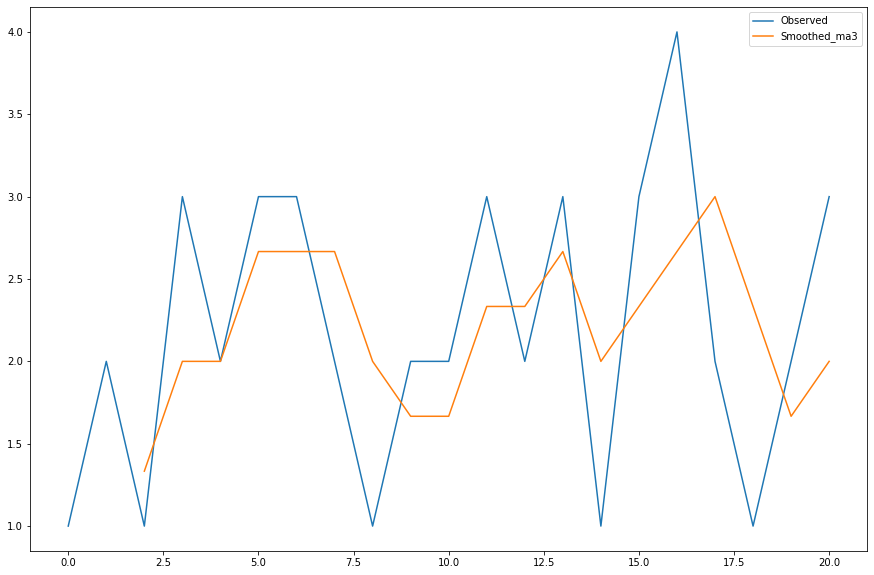

In [44]:
ma3_test_df.plot()

Smoothed version changes less dramatically then the observed data  
Now generalize everything by making a func that will take number of days to be used for smoothing  

<AxesSubplot:>

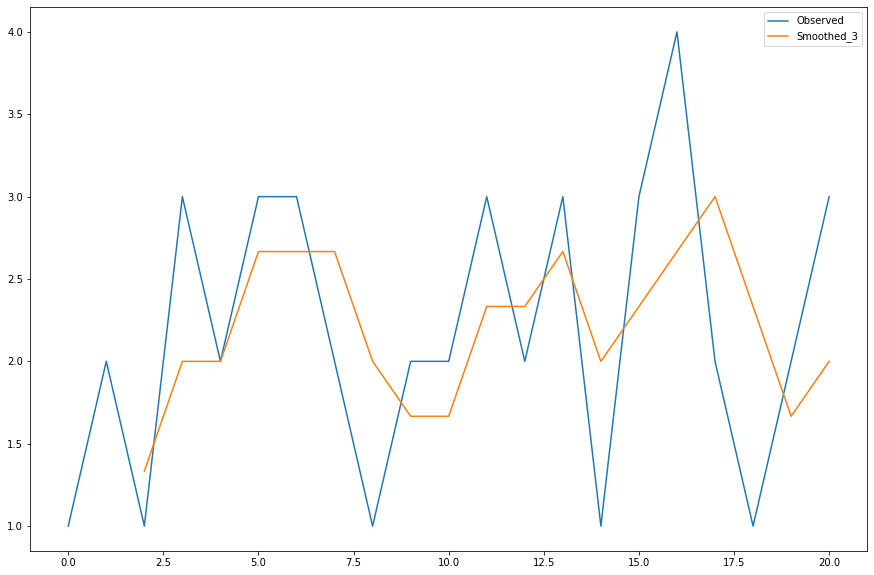

In [45]:
# built in pandas command for smoothing = `rolling`

def ma_smooth_pd(series, smoothing_days):
    answer = series.rolling(smoothing_days).mean()
    return answer

test_df_3_2 = pd.DataFrame(series, columns=['Observed'])
test_df_3_2['Smoothed_3'] = ma_smooth_pd(ma3_test_df['Observed'],3)
test_df_3_2.plot()

### Job vacancies example

In [46]:
job_df = pd.read_csv('./data/UK_job_vacancies.csv')
job_df.head()

,Month,Vacancies
0,2001 MAY,567.0
1,2001 JUN,563.0
2,2001 JUL,553.0
3,2001 AUG,552.0
4,2001 SEP,535.0


<AxesSubplot:>

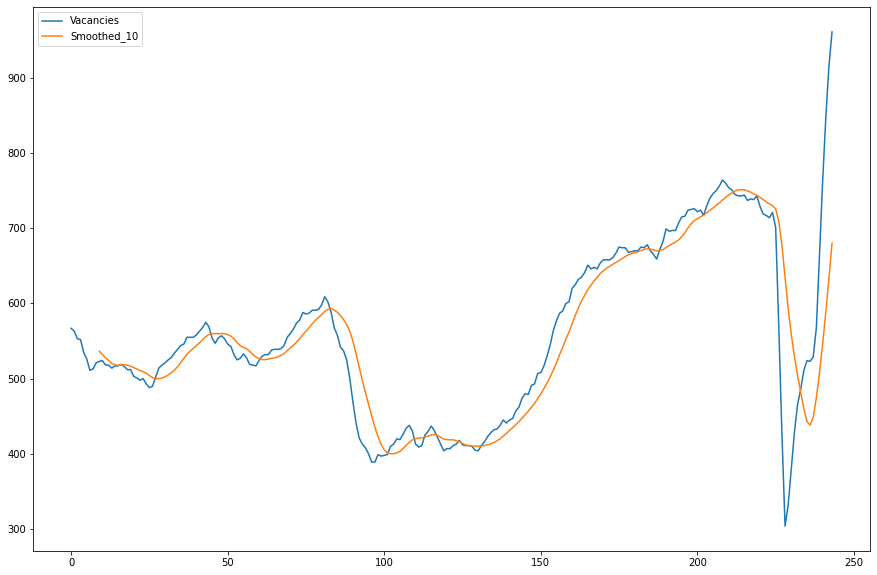

In [47]:
job_df['Smoothed_10'] = ma_smooth(job_df['Vacancies'], 10)
job_df.plot()

## 6.3 Exponential Smoothing

**The larger the alpha the less smoothing is done**


In [48]:
def exp_smooth(series, alpha):
    smoothed_value = series[0]
    results = []
    for value in series:
        smoothed_value = (1 - alpha) * smoothed_value + alpha * value
        results.append(smoothed_value)
    return results
series = [1, 2, 1, 3, 2, 3,3,2,1,2,2,3,2,3,1,3,4,2,1,2,3]

# exp_smooth(series,alpha)

df_test = pd.DataFrame(series, columns=['Observed'])
df_test['Smoothed_2'] = exp_smooth(df_test['Observed'], 0.2)
df_test.head()

,Observed,Smoothed_2
0,1,1.0000
1,2,1.2000
2,1,1.1600
3,3,1.5280
4,2,1.6224


<AxesSubplot:>

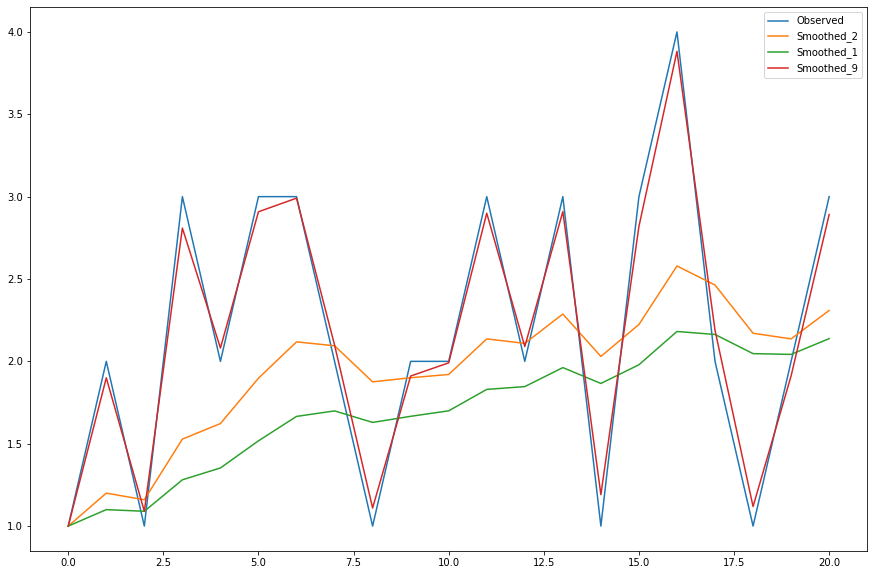

In [49]:
df_test ['Smoothed_1'] = exp_smooth(df_test['Observed'], 0.1)
df_test['Smoothed_9'] = exp_smooth(df_test['Observed'], 0.9)
df_test.plot()

#### German energy consumption example

In [50]:
consumption_df = pd.read_csv('./data/german_daily.csv')['Consumption'].to_frame()

consumption_df.head()
# consumption_df.plot()

,Consumption
0,1069.184
1,1380.521
2,1442.533
3,1457.217
4,1477.131


<AxesSubplot:>

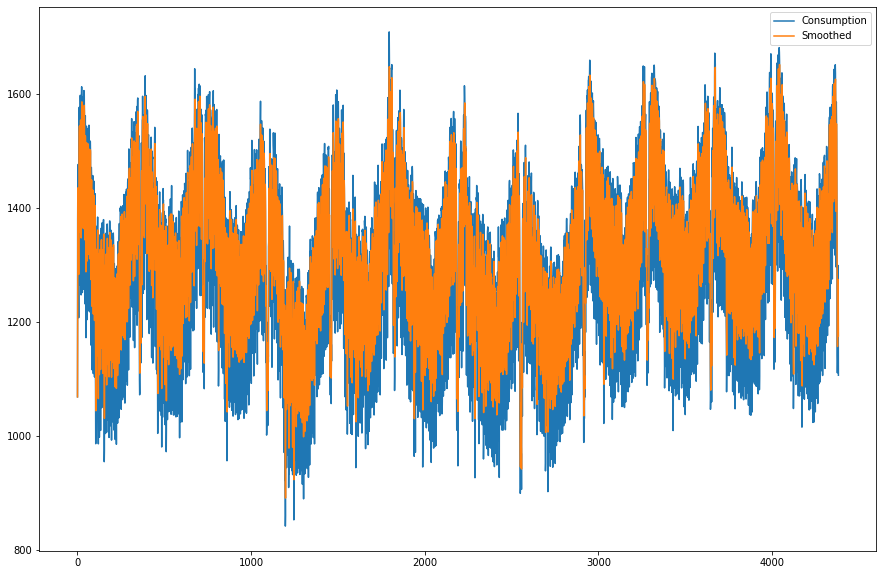

In [51]:
# smooth with alpha = 0.5

consumption_df['Smoothed'] = exp_smooth(consumption_df['Consumption'], 0.5)
consumption_df.plot()


First decomposition idea is to think of the time series as the trend plus the residue.   
So lets make a residue column and plot the frame.  


<AxesSubplot:>

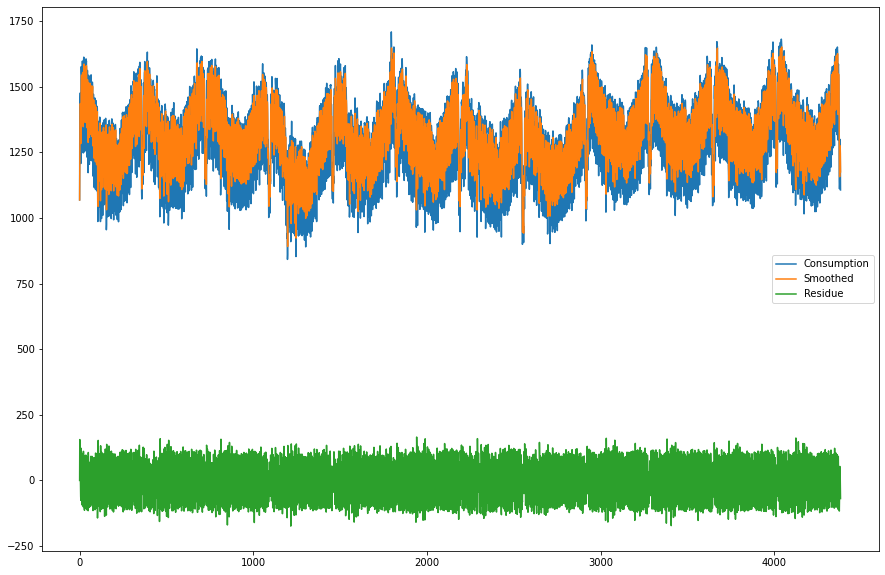

In [52]:
consumption_df['Residue'] = consumption_df['Consumption'] - consumption_df['Smoothed']
consumption_df.plot()

Do same thing but with libraries and Telsa stock

<AxesSubplot:xlabel='Date'>

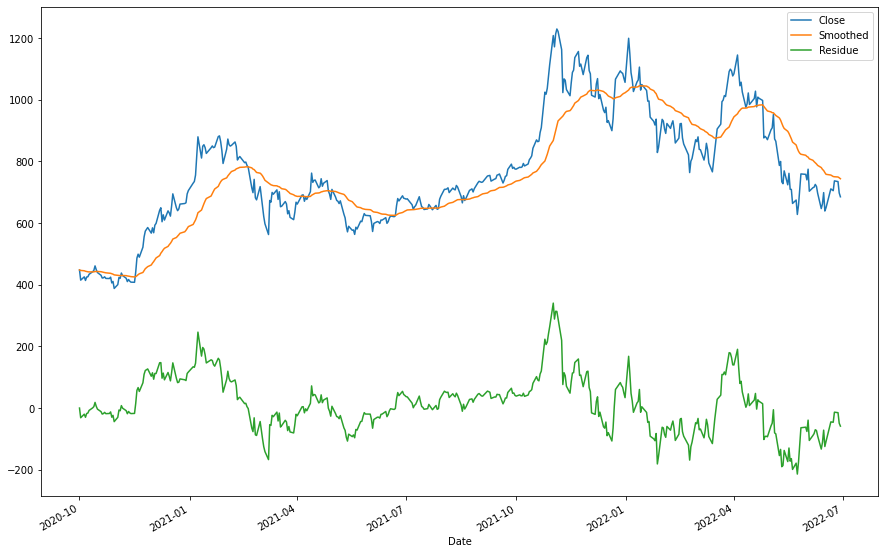

In [53]:
import yfinance as yf
tesla_frame = yf.Ticker('TSLA').history(start='2020-10-01', end='2022-06-30')['Close'].to_frame()
days = tesla_frame.index.date.astype('datetime64').astype(int)


tesla_frame['Smoothed'] = tesla_frame.ewm(alpha = 0.05, adjust=False).mean()
tesla_frame['Residue'] = tesla_frame['Close'] - tesla_frame['Smoothed']
tesla_frame.plot()

Moving averages window keeps moving along but stays same size  
Exponential smoothing, window keeps expanding to keep up  

Lowess - like a moving average but use it to get the value in the middle of the window instead of the end  
 - cant do it in real time
 - have to wait a bit to do it, have a lag

# 6.6 Lowess Smoothing

Local Weighted Scatterplot Smoothing  
Farther points away from smoothing line are weighted less - lower influence of outliers  

Main Idea of Lowess:
1. have a fixed-length moving window that you use to determine the smoothed value of the **middle** item.   
2. find the next value of the middle element by taking a **linear regression** on the **weighted neighbours**:   
    the weighting reflects that further neighbours (by x value) count less. The value of that line at the x-value of the item is the new y-value.   
    *(Note: I think that the difference between LOESS and LOWESS is that in the latter we actually fit a best-fitting parabola instead of a line, but writers are not consistent about this.)
3. You then have a new system of weights that includes the x-values as before but also weighs items less if the y value moved a lot in the last round. This is to limit the effect of outliers.
4. With the new weights, go back to 1. 

# 6.7 Exponential Trending Decomposition 

In the last lesson, we learned three methods of smoothing a time series. The smoothed version of the series is meant to give you the trend without the jagged variations.

In this lesson, we are going to use this to decompose the series into a trend and the rest. The rest we call, unnecessarily disparagingly in my view, the 'residue'. 

The residue is very important and we want it to be stationary so we can predict its value robustly. We will do some predictions using the decomposition. Later, we will learn also about bringing out a seasonality component.



<AxesSubplot:xlabel='Date'>

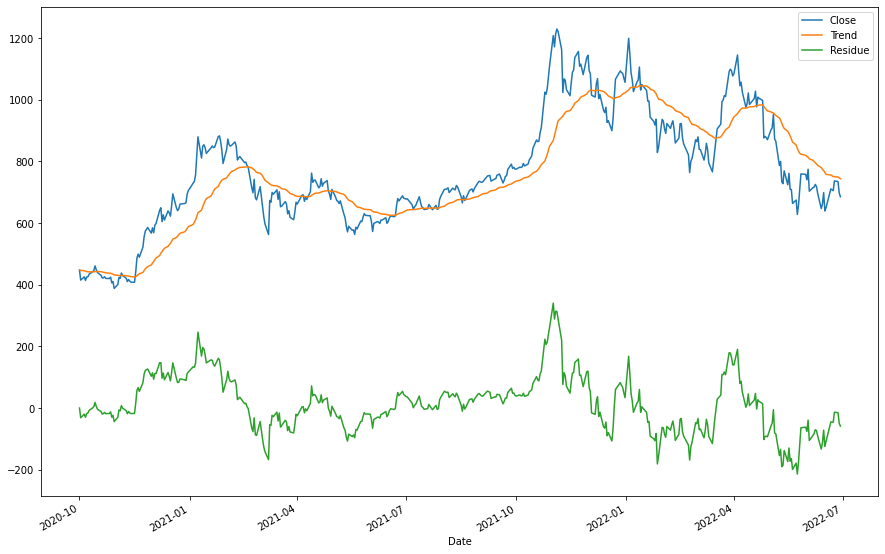

In [58]:
tesla_frame_decomp = yf.Ticker('TSLA').history(start='2020-10-01', end='2022-06-30')['Close'].to_frame()
days = tesla_frame_decomp.index.date.astype('datetime64').astype(int)

tesla_frame_decomp['Trend'] = exp_smooth(tesla_frame_decomp['Close'], 0.05)
tesla_frame_decomp['Residue'] = tesla_frame_decomp['Close'] - tesla_frame_decomp['Trend']
tesla_frame_decomp.plot()



**Now try to make the residue more stationary**  
Use the differences (derivative)

<AxesSubplot:xlabel='Date'>

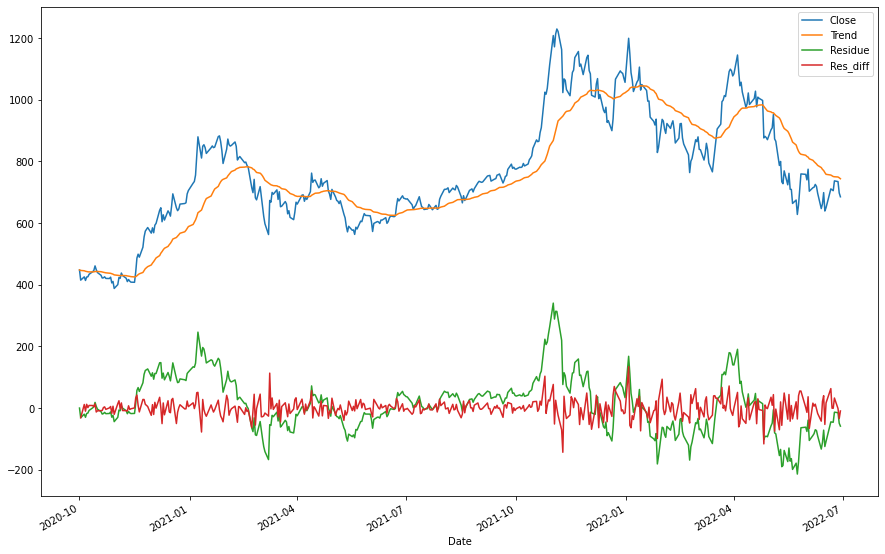

In [60]:
tesla_frame_decomp['Res_diff'] = tesla_frame_decomp['Residue'] - tesla_frame_decomp['Residue'].shift()

tesla_frame_decomp.plot()

Going to use naive differences to do the trending bit  
Use Autoregression to do the residue bit

*Note could add STATIONARITY TESTS to coursework as an extra bit


### Autoregression Code
Use to get coefficients for the Residual Differences
use AR(12) to do predictions on the residue differences

In [61]:
import numpy as np
def train_ar(values, order):
    target_vector = np.array(values[order:])
    lagged_values = []
    for i in range(len(values) - order):
        lagged_values.append(values[i:i+order])
    design_matrix = np.array(lagged_values)
    return np.linalg.inv(design_matrix.transpose() @ design_matrix) @ design_matrix.transpose() @ target_vector

In [63]:
# tesla_resid_diff_arcoefs = train_ar(tesla_frame_decomp['Res_diff'], 12)

# get array of [nan's] because first value of res_diff is nan and it propogates through
# need to drop nan

tesla_resid_diff_arcoefs = train_ar(tesla_frame_decomp.dropna()['Res_diff'], 12)
tesla_resid_diff_arcoefs

array([ 0.03000969, -0.05405864, -0.10667051,  0.05414313, -0.11198902,
        0.11256917, -0.04696829, -0.02783622,  0.01654323, -0.01338356,
       -0.05050945, -0.04126857])

### Use Predict from AR code to get **residual difference** prediction

In [64]:
import math

# takes the calculated AR coefficients and the residual difference data
# returns predicted values
def predict(coeffs, data):
    predicted_values = [math.nan] * len(coeffs) # we cannot predict the first few values
    for i in range(len(coeffs), len(data)):
        predicted_values.append(np.dot(coeffs, data[i-len(coeffs):i]))
    return np.array(predicted_values)

In [65]:
# get predicted difference
tesla_resid_diff_pred = predict(tesla_resid_diff_arcoefs, tesla_frame_decomp['Res_diff'])

# get predicted values by adding predicted difference to last obsvered value of Residue
tesla_residue_pred = tesla_resid_diff_pred + tesla_frame_decomp['Residue'].shift()


### Now predict the trend using **naive difference** method
Assume the last difference will be the same as the next.  
Ex. Monday 60, Tuesday 62, => predict Wednesday 64

In [67]:
tesla_trend_differences = (tesla_frame_decomp['Trend'].shift(1) - tesla_frame_decomp['Trend'].shift(2))

tesla_trend_pred = tesla_frame_decomp['Trend'].shift(1) + tesla_trend_differences

Now we have prediction for trend and prediction for residue.  
Add them together to get overall prediction.  

<AxesSubplot:xlabel='Date'>

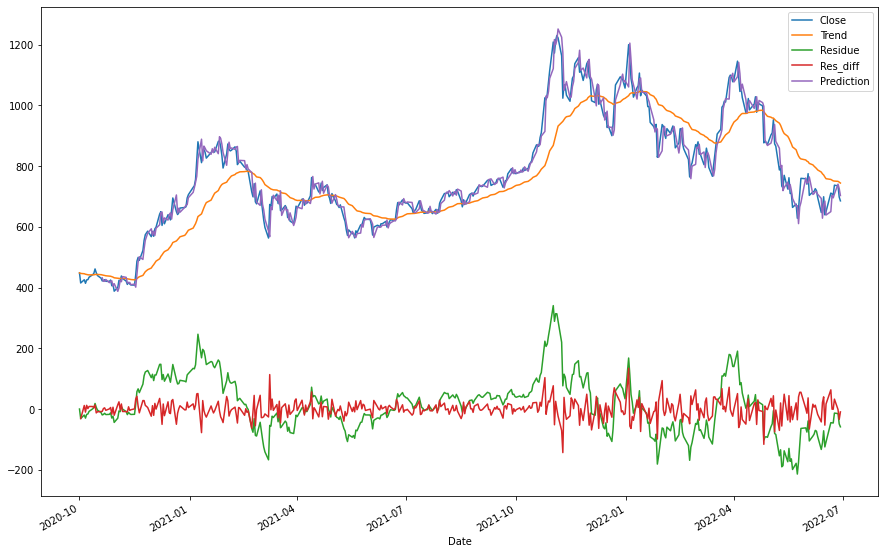

In [69]:
tesla_frame_decomp['Prediction'] = tesla_trend_pred + tesla_residue_pred
tesla_frame_decomp.plot()


<AxesSubplot:xlabel='Date'>

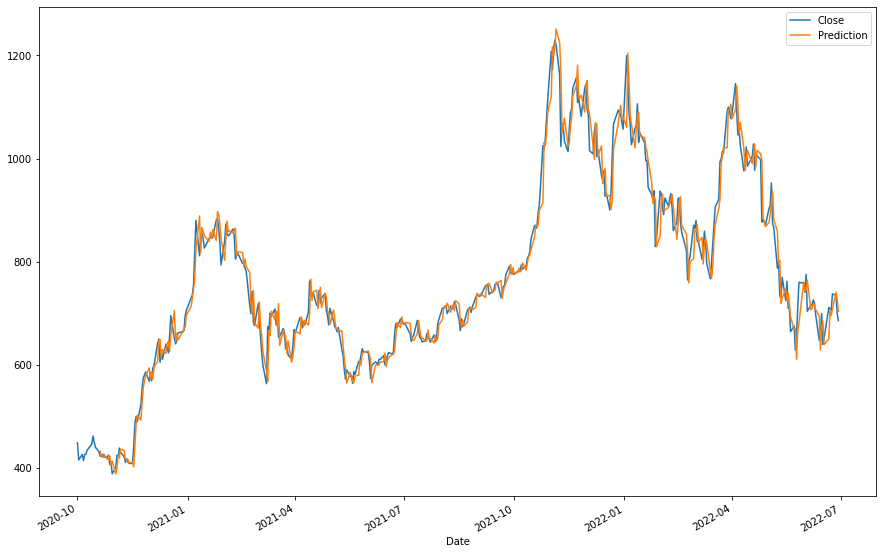

In [70]:
tesla_frame_recomp = tesla_frame_decomp.drop(columns=['Trend', 'Residue', 'Res_diff'])
tesla_frame_recomp.plot()

## 6.9 Seasonality Discovered

Seasonality is repeated periodic behaviour.

We will use a **fast fourier transform** to find that behaviour.  

The fft will spike at a frequency. The period will be the number of observations/frequency.  


<AxesSubplot:xlabel='Date'>

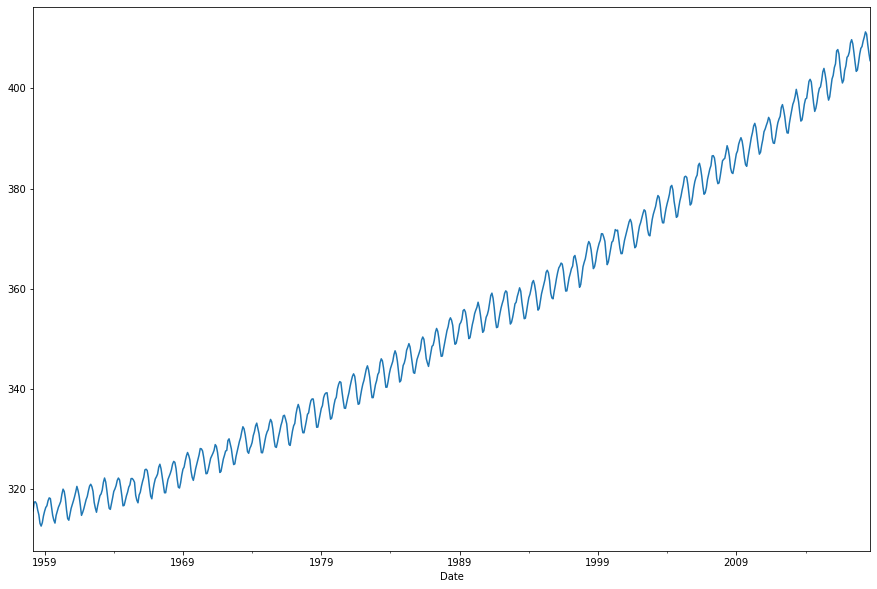

In [74]:
co2_df = pd.read_csv('./data/CO2_monthly.csv')
co2_df.index = pd.to_datetime(co2_df['Date'])
co2_df = co2_df['Interpolated'].rename('Observed')
co2_df.plot()

To avoid any funny business in the beginning I am going to start from 10. And I am only
going to go halfway up the series. 

That will make the behaviour of the graph easier to read. Those
two things are encapsulated in the phrase ```[10:len(co2_df)//2]``` 

Leading to the whole line of code:

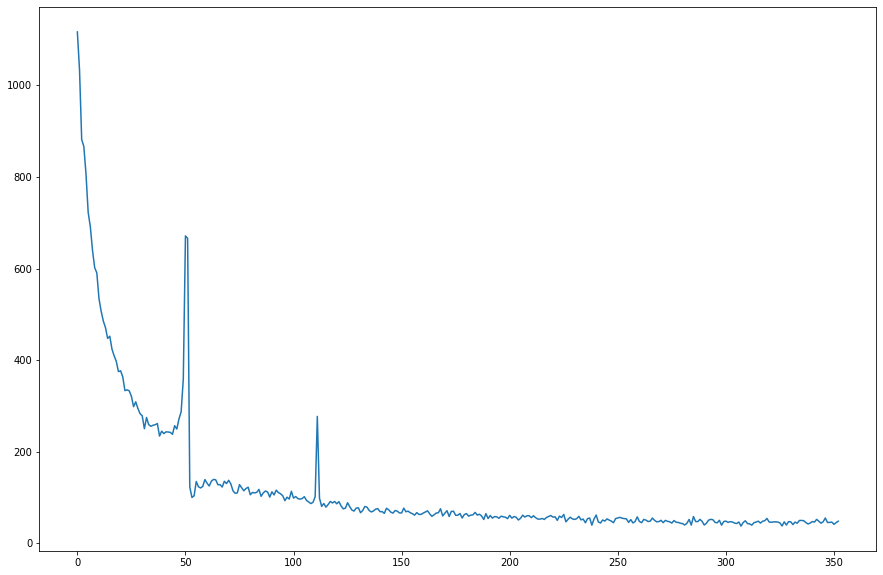

In [80]:


co2_fft = np.abs(np.fft.fft((co2_df)))[10:len(co2_df)//2]
plt.plot(co2_fft)

See spike at about 50, this is actually 60 since we started at 10. (We ignore the spike at the beginning)  

Know that there are 727 rows (observations).  

Period of regularity = 727/60 or 12.11 (1 year)

Comes out clearer if we start with 20 and plot only 1/8th of series.

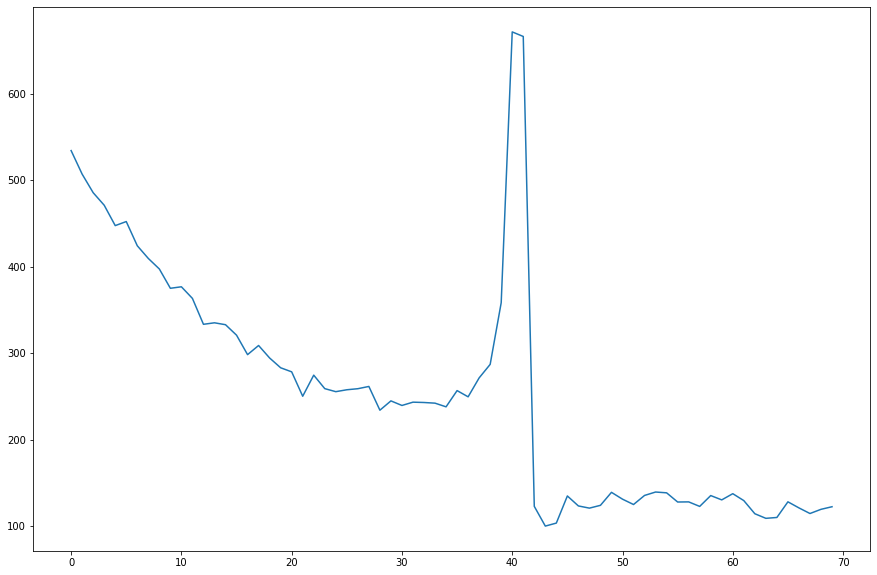

In [81]:
co2_fft2 = np.abs(np.fft.fft((co2_df)))[20:len(co2_df)//8]
plt.plot(co2_fft2)